# What is driving the log error in the Zestimates?
**1.** [**Project Plan**](#Project_Plan)<br>
**1.** [**Executive Summary**](#summary)<br>
**2.** [**Data Acquistion**](#acquire_data)<br>
**3.** [**Exploration**](#explore_data)<br>
**4.** [**Clustering**](#cluster_data)<br>
**5.** [**Modeling**](#model_data)<br>
**6.** [**Conclusions**](#conclusions)<br>

# Project Plan

### Background

> Using 2017 properties and prediction data from our Zillow database for single unit/single family homes, we were tasking with improving the log error (Zestimate)
> To accomplish this the team used clustering methodologies to find patterns in terms of which features had the greatest effect on log error
> Using the features which produced the best clusters, create a model to predict logerror

### Goals

> We will be using the ML Clustering Algorithm KMeans to find clusters within the data to improve our estimate of the log error. Once those clusters have been identified, we will use Regression models to test the efficacy of the clustering work.

### Deliverables
**The deliverables for this project are the following data assets:**
- Report detailing our analysis in an .ipynb format
- Detailed README on a Github and repo containing all files for this project
- All .py files that are necessary to reproducible work

<a id='summary'></a>

# Executive Summary

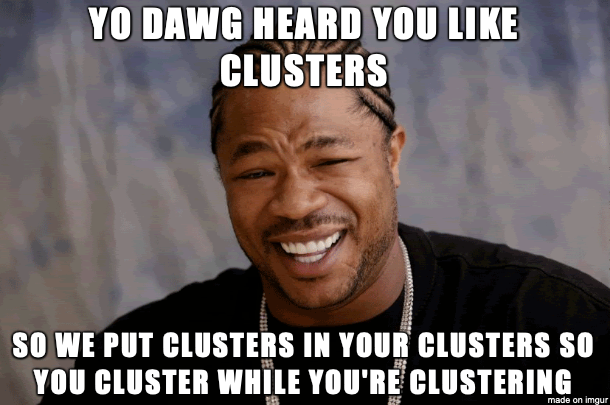

In [2]:
Image(filename="clustering.png", width=800)

In [3]:
conclusion

<button class="button-save large">[Clustering Zillow Logerror](https://chasethompson.github.io)</button>

<a id='Project_Plan'></a>

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# general
import pandas as pd
import numpy as np

# explore/ stat
import scipy.stats as stats

# visuals
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

# support modules
import acquire
import wrangle
import prepare
import split_scale
import cluster
import model

# modeling
from sklearn.cluster import KMeans, dbscan
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

# view full DF
pd.set_option('display.max_columns', None)

# some handy functions to use along widgets
from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets

# our conclusion button
button = widgets.Button(description='Our Conclusion')
out = widgets.Output()
def on_button_clicked(_):
      # "linking function with output"
      with out:
          # what happens when we press the button
          clear_output()
          print('Hypothesis and conclusion is unclear.')
          print('Our derived variables proved useful, but not significantly.')
          print('The "best" performing model was a random forest regressor.')
# linking button and function together using a button's method
button.on_click(on_button_clicked)

conclusion = widgets.VBox([button,out])

import os
from IPython.display import Image
from ipywidgets import interact, interact_manual

<a id='acquire_data'></a>

# Aquisition and Prep

**Retrieve from the Codeup Zillow_db:**

- Latest transactions occured within the year of 2017 for each property
- Logerror
- All fields related to each properties
    - Fields known to have greater than 60% nulls were excluded from the query
- Gather descriptions by joining description tables
- Only properties where latitude and longitude are not null
- Only properties where bedroom and bathroom count were not 0
- Only single family homes (SFR)

To create this dataframe use the get_zillow_data function from the acquire.py file

In [4]:
df = acquire.get_zillow_data()

df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
0,14297519,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,2017-01-01
1,17052889,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01
2,14186244,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01
3,12177905,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01
4,10887214,3.0,3.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,1964.0,73681.0,119407.0,45726.0,1533.89,0.006940,2017-01-01


### The following transofmations we achieved through a series of functions:
> - ensure there are no nulls
> - remove all outliers are removed
> - create dervied features 
> - assigned intuitive names to each feature

- All datatypes are appropriate for our use

In [5]:
df.shape

(76725, 15)

In [6]:
df.isnull().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
calculatedfinishedsquarefeet      11
fips                               0
latitude                           0
longitude                          0
lotsizesquarefeet               8152
yearbuilt                         65
structuretaxvaluedollarcnt        87
taxvaluedollarcnt                  1
landtaxvaluedollarcnt              1
taxamount                          5
logerror                           0
transactiondate                    0
dtype: int64

In [7]:
df = wrangle.handle_nulls(df)
df.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
logerror                        0
transactiondate                 0
dtype: int64

**Create synthetic features**

In [8]:
df = wrangle.prepare_zillow(df)

df = prepare.tax_rate(df)

In [9]:
# remove outliers in these coloumns
col_out = ["bathroomcnt", "bedroomcnt", "tax_rate", "calculatedfinishedsquarefeet", 
           "lotsizesquarefeet", "structuretaxvaluedollarcnt", "taxvaluedollarcnt", "landtaxvaluedollarcnt"]

df = prepare.remove_outliers_iqr(df, col_out)

- We noticed there were still a few features with some extreme values so we employed a more conventional method

In [10]:
# Additional outlier removal
df = df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 7) & 
         (df.bathroomcnt > 0) & 
         (df.bedroomcnt > 0) & 
         (df.calculatedfinishedsquarefeet < 7000) & 
         (df.tax_rate < .05)
        )]

In [11]:
df = prepare.bed_bath_ratio(df)
df = prepare.better_names(df)

In [12]:
df.head()

,longitude,latitude,age,bedroomcnt,bathroomcnt,square_footage,lot_size,house_value,land_value,full_value,tax_rate,Los_Angeles,Orange,Ventura,logerror,bed_bath_ratio
0,-117869207.0,33634931.0,19.0,4.0,3.5,3100.0,4506.0,485713.0,537569.0,1023282.0,0.010763,0,1,0,0.025595,1.142857
1,-119281531.0,34449266.0,50.0,2.0,1.0,1465.0,12647.0,88000.0,376000.0,464000.0,0.012225,0,0,1,0.055619,2.000000
2,-117823170.0,33886168.0,55.0,3.0,2.0,1243.0,8432.0,85289.0,479489.0,564778.0,0.011488,0,1,0,0.005383,1.500000
3,-118240722.0,34245180.0,47.0,4.0,3.0,2376.0,13038.0,108918.0,36225.0,145143.0,0.012247,1,0,0,-0.103410,1.333333
5,-118993991.0,34230044.0,35.0,3.0,2.0,1492.0,903.0,198640.0,132424.0,331064.0,0.010596,0,0,1,-0.020526,1.500000


In [13]:
df.shape

(59930, 16)

<a id='explore_data'></a>

# Exploration

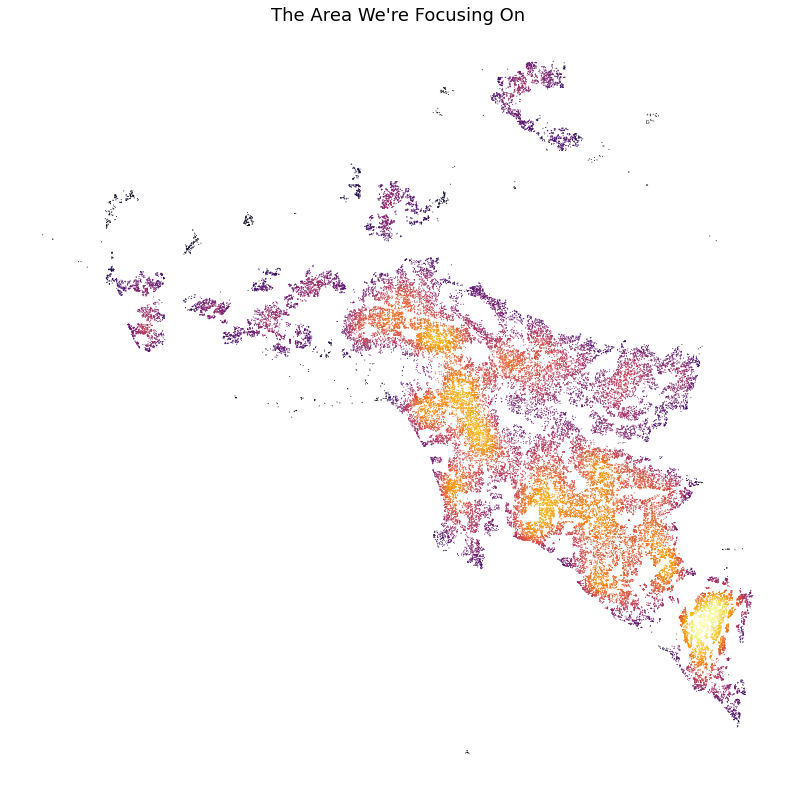

In [14]:
parcelDensity30000 = cluster.get_pde(df,30000)

plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("The Area We're Focusing On", fontsize=18)
plt.scatter(df['longitude'].values, df['latitude'].values, c=parcelDensity30000,cmap='inferno', s=1, edgecolor='')
plt.show()

## Split and Scale

- The data was split into train and test dataframes (70% and 30% respectively). A random seed was set for reproducibility.
- Both sets of data were scaled using the MinMax scaler from SKlearn

In [15]:
train, test = split_scale.train_test(df)
print('train:', train.shape)
print('test:', test.shape)

train: (41951, 16)
test: (17979, 16)


In [16]:
train.head()

,longitude,latitude,age,bedroomcnt,bathroomcnt,square_footage,lot_size,house_value,land_value,full_value,tax_rate,Los_Angeles,Orange,Ventura,logerror,bed_bath_ratio
44758,-118476118.0,34061074.0,78.0,3.0,2.0,2898.0,7070.0,375122.0,244299.0,619421.0,0.013315,1,0,0,1.775059,1.5
76378,-117984001.0,34019979.0,61.0,4.0,2.0,1937.0,6048.0,179233.0,218384.0,397617.0,0.011867,1,0,0,-0.116786,2.0
3539,-118461331.0,33974843.0,48.0,4.0,5.0,3199.0,2884.0,309266.0,924804.0,1234070.0,0.012103,1,0,0,0.008819,0.8
35048,-117922000.0,33854800.0,54.0,2.0,2.0,1157.0,7201.0,81120.0,193295.0,274415.0,0.012080,0,1,0,-0.017483,1.0
31603,-117687326.0,33522157.0,31.0,3.0,3.0,1555.0,8600.0,167386.0,327332.0,494718.0,0.010014,0,1,0,0.006042,1.0


In [17]:
scaler, train_scaled, test_scaled = split_scale.min_max_scaler(train, test)

### Target Exploration: Logerror

In [18]:
# code to regulate the size of plots for the rest of notebook
plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=13)

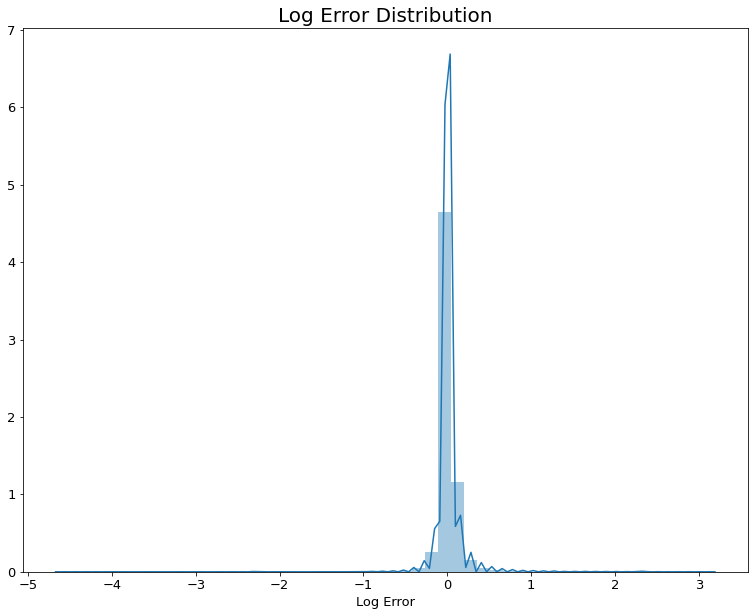

In [19]:
# overall logerror distribution 
sns.distplot(df.logerror)
plt.title('Log Error Distribution', fontsize=20)
plt.xlabel('Log Error')

plt.show()

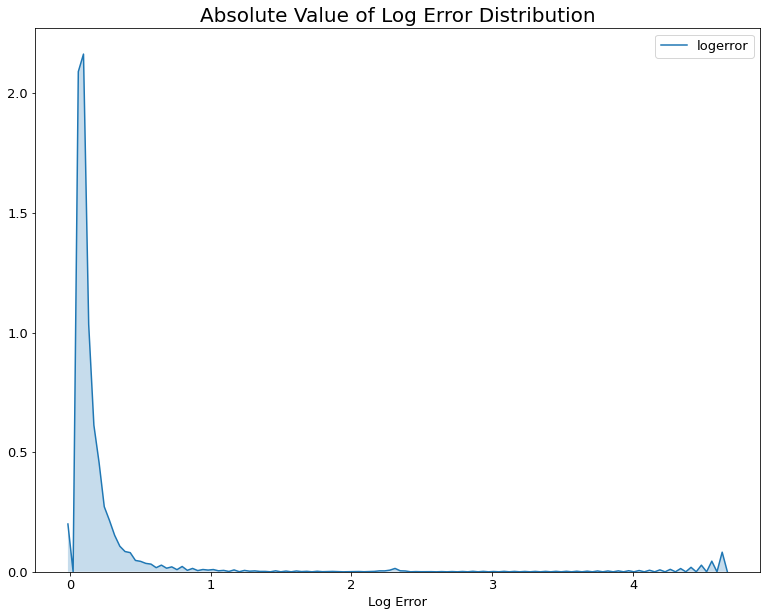

In [20]:
# absolute value of logerror
sns.kdeplot(df.logerror.abs(), shade=True)

plt.title('Absolute Value of Log Error Distribution', fontsize=20)
plt.xlabel('Log Error')

plt.show()

### Let's look at the correlation between the target variable and all other variables

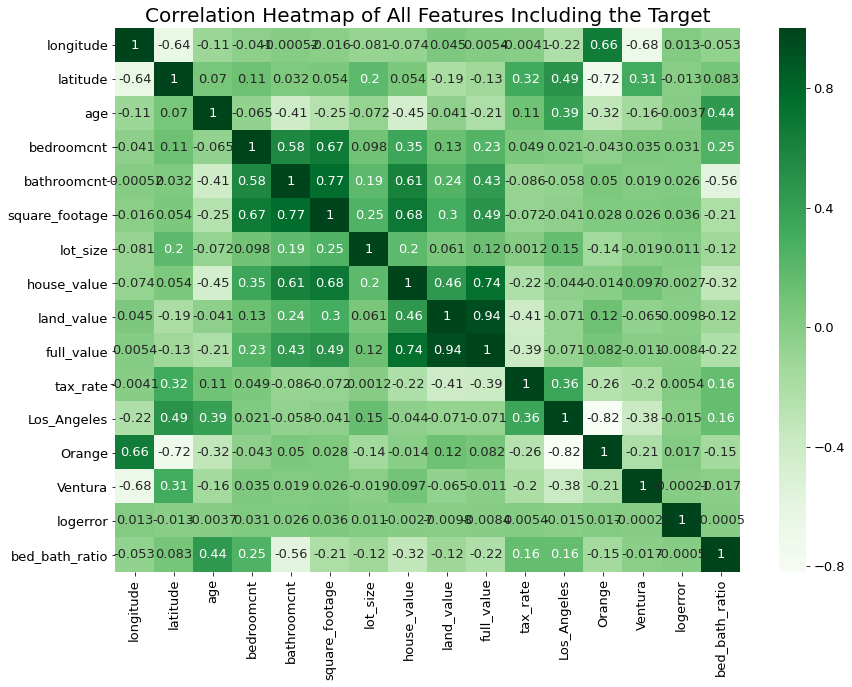

In [21]:
# Heatmap to display correlation of the features and logerror.
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), cmap='Greens', annot=True)
plt.title('Correlation Heatmap of All Features Including the Target', fontsize=20)
plt.show()

### The heatmap doesn't show any particulary high linear correlation but there could still be certain features that have more of an impact on the target variable

#### Let's take a closer look at some specific features :

#### Is there a relationship between Bathroom count or Bedroom count and Logerror?

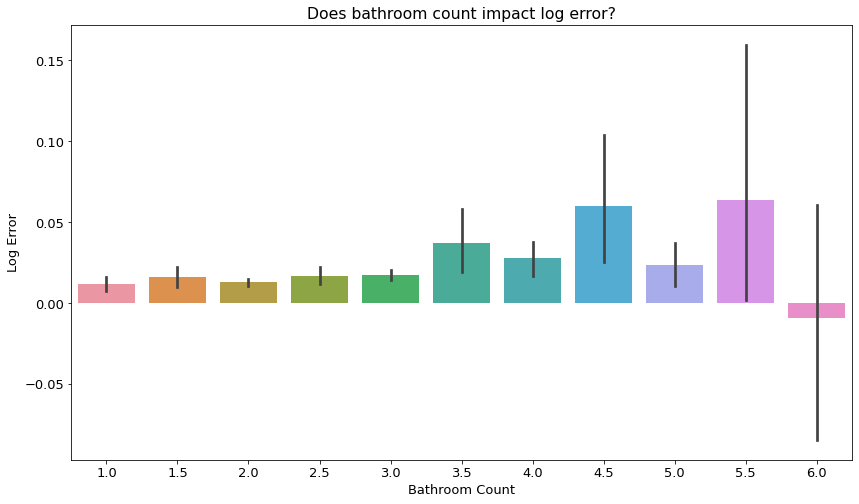

In [22]:
plt.figure(figsize=(14,8))
with sns.color_palette('Blues'):
    sns.barplot(x='bathroomcnt', y='logerror', data=train)
plt.xlabel('Bathroom Count')
plt.ylabel('Log Error')
plt.title('Does bathroom count impact log error?')
plt.show()

### It looks like homes with smaller bathroom counts tend to produce smaller log error,
> ### There are some major errors with home of 6 bathrooms
> ### This could possibly be a driver of log error. We'll keep this feature in mind when whe head to clustering and futher modeling

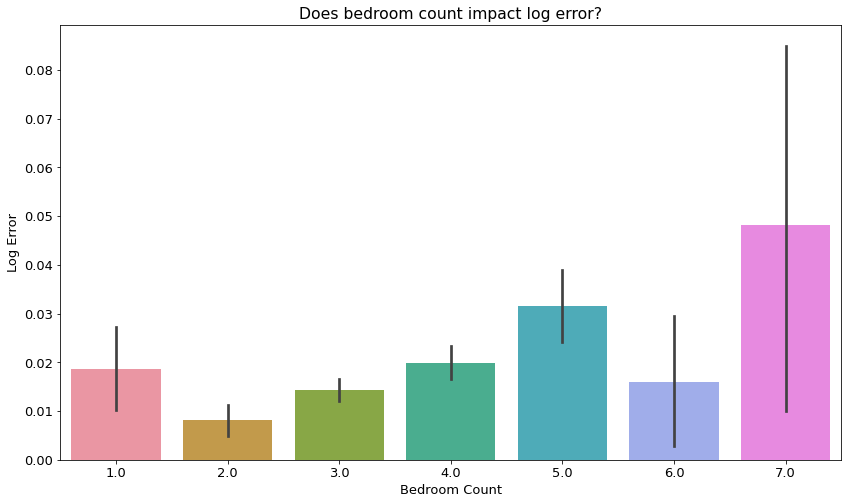

In [23]:
plt.figure(figsize=(14,8))
with sns.color_palette("Blues"):
    sns.barplot(x='bedroomcnt', y='logerror', data=train)
plt.xlabel('Bedroom Count')
plt.ylabel('Log Error')
plt.title('Does bedroom count impact log error?')
plt.show()


### Bedroom count also shows some increse in logerror at higher counts
> #### These are the two home features that we can vizually see some variation in log error


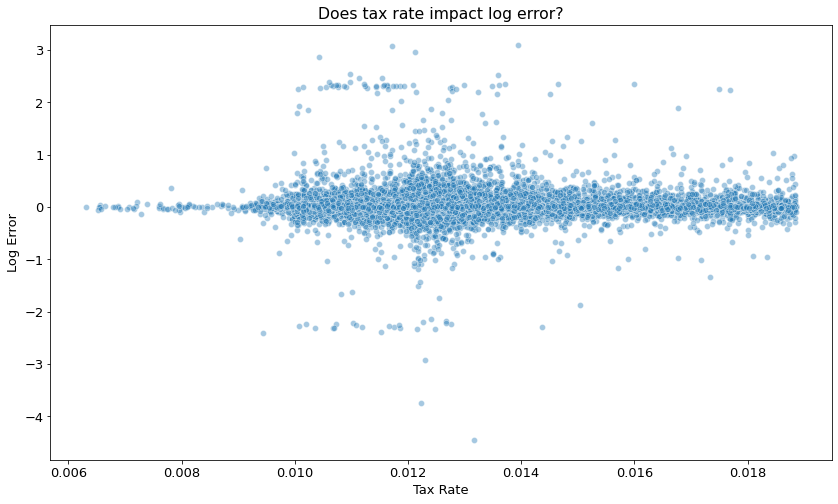

In [24]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='tax_rate', y='logerror', data=train, alpha=.4)
plt.xlabel('Tax Rate')
plt.ylabel('Log Error')
plt.title('Does tax rate impact log error?')
plt.show()

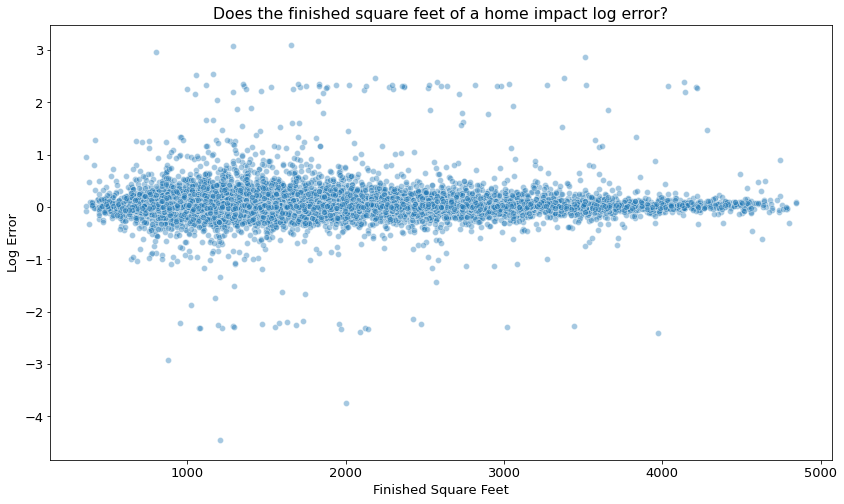

In [25]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='square_footage', y='logerror', data=train, alpha=.4)
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')
plt.title('Does the finished square feet of a home impact log error?')
plt.show()

During this section, we identified patterns in the data which may help to isolate which features were most helpful in improving log error.

- Hypothesis testing in this section assesses the level of correlation between our independent variables and between our independent and target variables

### Feature/Feature Hypothesis
- $H_0$: Bedroom and bathroom count are not related
- $H_a$: Bedroom and bathroom count are related
- _alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)_

In [26]:
x = train_scaled.bedroomcnt
y = train_scaled.bathroomcnt

alternative_hypothesis = 'bedroom count is related to bathroom count'
alpha = .05

corr, p = stats.pearsonr(x, y)

corr, p

if p < alpha:
    print("We reject the null hypothesis")
    print("We can say that we have confidence that", alternative_hypothesis)
else:
    print("We fail to reject the null")

We reject the null hypothesis
We can say that we have confidence that bedroom count is related to bathroom count


### Value/Target Hypothesis
- $H_0$: Overall home value has no effect on logerror
- $H_a$: Over home value does have an effect on logerror
- _alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)_

In [27]:
x = train_scaled.house_value
y = train_scaled.logerror

alternative_hypothesis = 'house value is related to logerror'
alpha = .05

corr, p = stats.pearsonr(x, y)

corr, p

if p < alpha:
    print("We reject the null hypothesis")
    print("We can say that we have confidence that", alternative_hypothesis)
else:
    print("We fail to reject the null")
    
p

We fail to reject the null


0.42749879868985013

Text(0.5, 1.0, 'Logerror vs House Value')

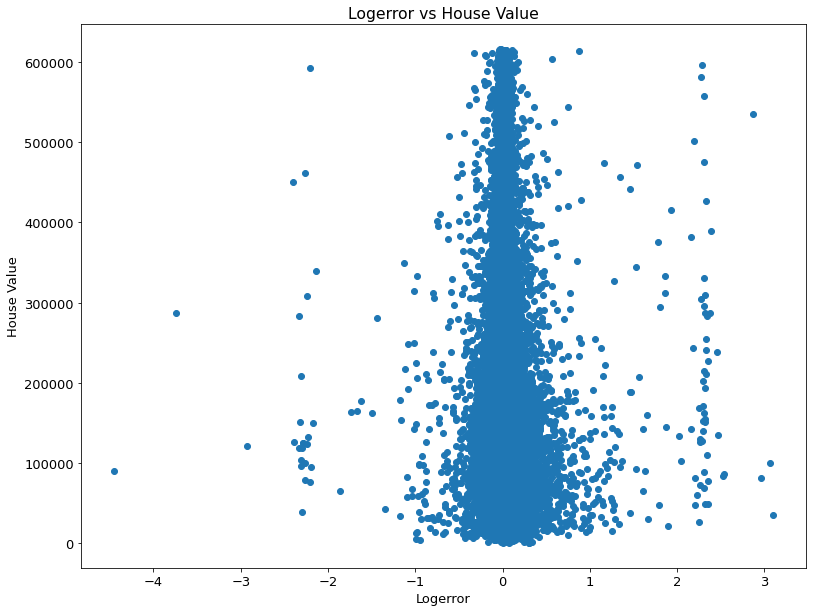

In [28]:
plt.scatter(train.logerror,train.house_value)
plt.xlabel('Logerror')
plt.ylabel('House Value')
plt.title('Logerror vs House Value')

### We can confirm that although logerror and house_value are not necessarily linearly correlated, they do seem to have some sort of relationship with each other. 

#### We'll look into using house_value as a feature to cluster and perhaps model with it



# Clustering

### Features were grouped into 4 categories:
> - **Physical position**
> - **Age of home**
> - **Value of home**
> - **Home features**

**We constructed several clusters using unique combinations of these features and evaluated them using ttests to determine significance of relationship between each group within the cluster and the target variable *logerror*.**

Our two best performing clusters are displayed below:

### First Cluster groups according to physical position and home features
> - **Latitude**
> - **Longitude**
> - **Lot_size**
> - **Square_footage**

In [29]:
cluster_vars = train_scaled[['latitude', 'longitude', 'lot_size', 'square_footage']]
cluster_col_name = 'location_size'
centroid_col_names = ['centroid_' + i for i in cluster_vars]

     k          sse
0    2  3296.411386
1    3  2740.697795
2    4  2283.863022
3    5  2008.041521
4    6  1773.671055
5    7  1607.234716
6    8  1472.182979
7    9  1358.974940
8   10  1281.352147
9   11  1211.234827
10  12  1147.532823
11  13  1096.730763
12  14  1055.136510


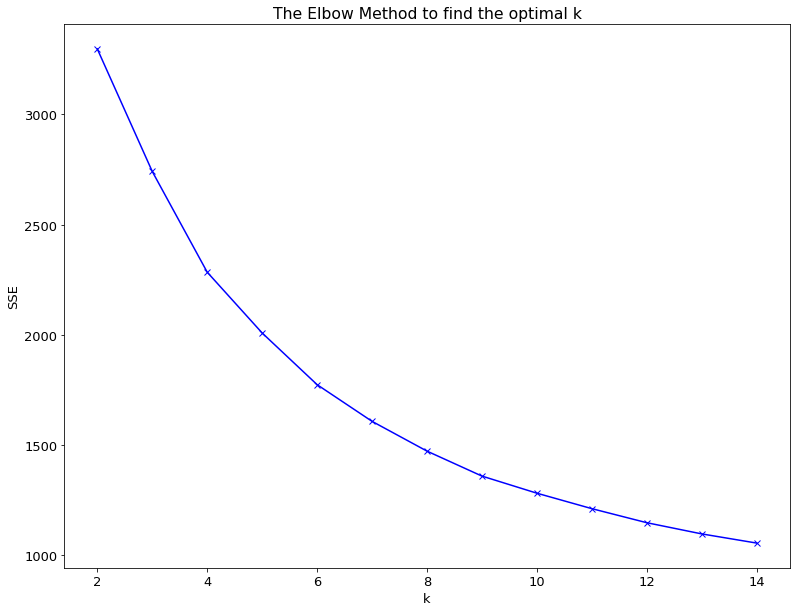

In [30]:
#determine what the best k (number of groups) is
optimal_k = cluster.elbow_method(cluster_vars)

### Went with a k of 5

In [31]:
# Function to obtain:
# The train clusters with their observations,
# test clusters and their observations
# and a df of the number of observations per cluster on train
kmeans, train_clusters, test_clusters, cluster_counts = cluster.get_clusters_and_counts(5, ['latitude', 'longitude',
                                                                                           'lot_size', 'square_footage'], 
                                                                                        'location_size', train_scaled, test_scaled)

In [32]:
X_train_scaled = train_scaled[["latitude","longitude","square_footage", "lot_size", "full_value","age", "lot_size"]]
X_test_scaled = test_scaled[["latitude","longitude", "square_footage", "lot_size", "full_value","age", "lot_size"]]

In [33]:
# Function to obtain:
# dataframe of the train clusters with their observations, 
# test clusters and their observations
# and a df of the number of observations per cluster on train. 
X_train_scaled, train_scaled, X_test_scaled, test_scaled, centroids = cluster.append_clusters_and_centroids(
                                X_train_scaled, train_scaled, train_clusters, 
                                X_test_scaled, test_scaled, test_clusters, 
                                cluster_col_name, centroid_col_names, kmeans)

In [34]:
X_train_scaled.head()

,latitude,longitude,square_footage,lot_size,full_value,age,lot_size,location_size,centroid_latitude,centroid_longitude,centroid_lot_size,centroid_square_footage
44758,0.522594,0.520456,0.565886,0.288830,0.381740,0.401042,0.288830,2,0.365776,0.781547,0.316564,0.537618
76378,0.492830,0.776761,0.351616,0.245636,0.241751,0.312500,0.245636,0,0.466386,0.683060,0.250492,0.222897
3539,0.460140,0.528157,0.632999,0.111914,0.769668,0.244792,0.111914,2,0.365776,0.781547,0.316564,0.537618
35048,0.373196,0.809053,0.177703,0.294366,0.163993,0.276042,0.294366,1,0.247339,0.871385,0.249470,0.242612
31603,0.132273,0.931276,0.266444,0.353493,0.303035,0.156250,0.353493,1,0.247339,0.871385,0.249470,0.242612


### Second Cluster groups according to one home feature, the age of the home and one value feature
> - **Lot_size**
> - **Age**
> - **full_value**

In [35]:
# Define variables
cluster_vars = train_scaled[['lot_size', 'age', 'full_value']]
cluster_col_name = 'size_age_value'
centroid_col_names = ['centroid_' + i for i in cluster_vars]

     k          sse
0    2  1999.728929
1    3  1491.500905
2    4  1200.398521
3    5  1047.792046
4    6   933.746843
5    7   847.663941
6    8   771.105432
7    9   696.330753
8   10   643.621568
9   11   594.642059
10  12   558.237315
11  13   524.054110
12  14   499.188921


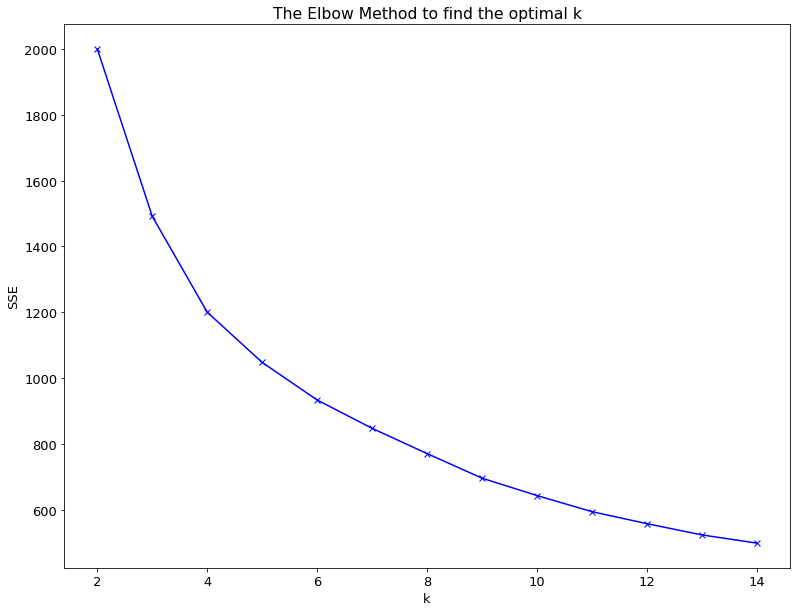

In [36]:
#determine what the best k (number of groups) is
optimal_k = cluster.elbow_method(cluster_vars)

### Again we went with a k of 5

In [37]:
# Function to obtain:
# The train clusters with their observations,
# test clusters and their observations
# and a df of the number of observations per cluster on train
kmeans, train_clusters, test_clusters, cluster_counts = cluster.get_clusters_and_counts(5, ['age',
                                                                                           'lot_size', 'full_value'], 
                                                                                        'size_age_value', train_scaled, test_scaled)

In [38]:
# Function to obtain:
# dataframe of the train clusters with their observations, 
# test clusters and their observations
# and a df of the number of observations per cluster on train. 
X_train_scaled, train_scaled, X_test_scaled, test_scaled, centroids = cluster.append_clusters_and_centroids(
                                X_train_scaled, train_scaled, train_clusters, 
                                X_test_scaled, test_scaled, test_clusters, 
                                cluster_col_name, centroid_col_names, kmeans)

In [39]:
X_train_scaled.head()

,latitude,longitude,square_footage,lot_size,full_value,age,lot_size,location_size,centroid_latitude,centroid_longitude,centroid_lot_size_x,centroid_square_footage,size_age_value,centroid_lot_size_y,centroid_age,centroid_full_value
44758,0.522594,0.520456,0.565886,0.288830,0.381740,0.401042,0.288830,2,0.365776,0.781547,0.316564,0.537618,1,0.346734,0.283686,0.308823
76378,0.492830,0.776761,0.351616,0.245636,0.241751,0.312500,0.245636,0,0.466386,0.683060,0.250492,0.222897,1,0.346734,0.283686,0.308823
3539,0.460140,0.528157,0.632999,0.111914,0.769668,0.244792,0.111914,2,0.365776,0.781547,0.316564,0.537618,2,0.199442,0.309280,0.591614
35048,0.373196,0.809053,0.177703,0.294366,0.163993,0.276042,0.294366,1,0.247339,0.871385,0.249470,0.242612,3,0.338391,0.267762,0.100718
31603,0.132273,0.931276,0.266444,0.353493,0.303035,0.156250,0.353493,1,0.247339,0.871385,0.249470,0.242612,0,0.143041,0.246687,0.235677


### Cluster Evaluation

In [40]:
cluster.test_sig(X_train_scaled.location_size, train_scaled)

,ttest,pval,stat_sig
0,4.677274,0.000003,True
1,-2.903274,0.003698,True
2,-0.024052,0.980812,False
3,1.106744,0.268485,False
4,-1.917004,0.055267,False


Text(0.5, 1.0, 'Square Footage vs. Lot Size colored by Cluster')

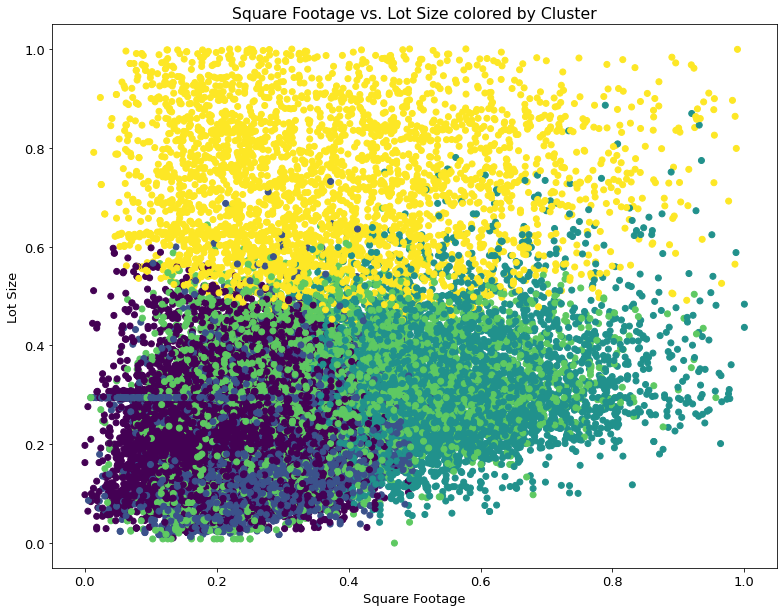

In [41]:
plt.scatter(train_scaled.square_footage, train_scaled.lot_size, c=X_train_scaled.location_size)
plt.xlabel('Square Footage')
plt.ylabel('Lot Size')
plt.title('Square Footage vs. Lot Size colored by Cluster')

In [42]:
cluster.test_sig(X_train_scaled.size_age_value, train_scaled)

,ttest,pval,stat_sig
0,-3.960191,0.000076,True
1,1.367408,0.171563,False
2,3.810828,0.000139,True
3,-3.619161,0.000297,True
4,1.499900,0.133734,False


Text(0.5, 1.0, 'Age vs. Full Value colored by Cluster')

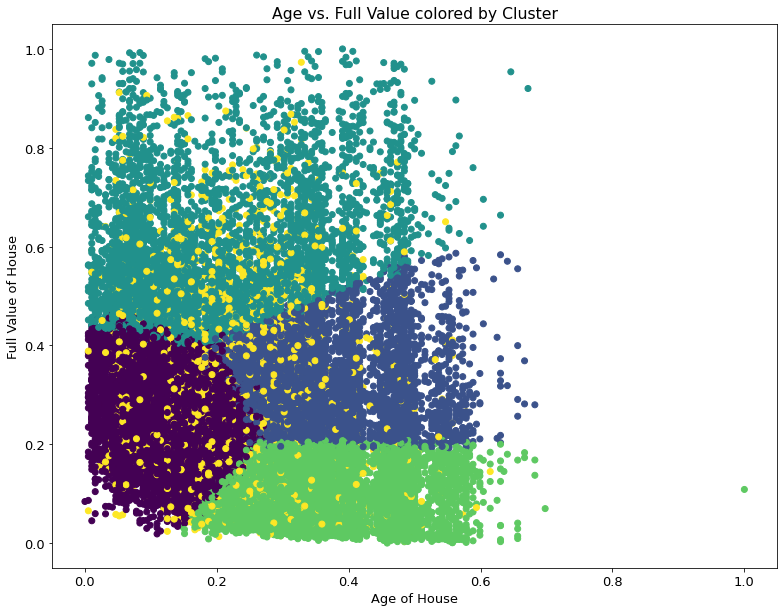

In [43]:
plt.scatter(train_scaled.age, train_scaled.full_value, c=X_train_scaled.size_age_value)
plt.xlabel('Age of House')
plt.ylabel('Full Value of House')
plt.title('Age vs. Full Value colored by Cluster')

<a id='cluster_data'></a>

<a id='model_data'></a>

# Modeling

Use selected features or clustered data to predict the target logerror

1. Algorithms used:

> linear regression, decision tree regressor, random forest regressor

Data for modeling:

> all select features via clustering and clusters generated using selected features

3. Validate with out-of-sample data (test-set)

> Random Forest Regressor performed the best and better than the baseline

In [44]:
# Splitting out X and Y variables for modeling

X_train = train_scaled[['lot_size','age','full_value','longitude','latitude','square_footage']]
y_train = train_scaled[['logerror']]

X_test = test_scaled[['lot_size','age','full_value','longitude','latitude','square_footage']]
y_test = test_scaled[['logerror']]

In [45]:
# Creating a dataframe of the actual log errors for comparision throughout modeling process
predictions = y_train[['logerror']]
predictions = predictions.rename(columns={'logerror': 'actual'})
predictions.head()

,actual
44758,0.824503
76378,0.574090
3539,0.590715
35048,0.587234
31603,0.590348


In [46]:
# Creating a baseline model
X_train = train_scaled[['lot_size','age','full_value','longitude','latitude','square_footage']]
y_train = train_scaled[['logerror']]

y_train['mean_logerror'] = y_train.logerror.mean()
rmse_baseline = np.sqrt(mean_squared_error(y_train.logerror, y_train.mean_logerror))
r2_baseline = r2_score(y_train.logerror, y_train.mean_logerror)

predictions['rsme_baseline'] = ('{:.4f}'.format(rmse_baseline))
print('This is the baseline dataset model performance')
print(f'RSME = {rmse_baseline:.4f}')
print(f'R2 score =  {r2_baseline:.4f}')

This is the baseline dataset model performance
RSME = 0.0216
R2 score =  0.0000


In [47]:
# Create decision tree regressor
X_train = train_scaled[['lot_size','age','full_value','longitude','latitude','square_footage']]
y_train = train_scaled[['logerror']]

regressor = DecisionTreeRegressor(max_depth = 8, random_state=121)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)

rmse_dt_train = np.sqrt(mean_squared_error(y_train, y_pred))
r2_dt_train = r2_score(y_train, y_pred)

predictions['rsme_dt'] = ('{:.4f}'.format(rmse_dt_train))
print('This is the train dataset model performance')
print(f'RSME = {rmse_dt_train:.4f}')
print(f'R2 score =  {r2_dt_train:.4f}')

This is the train dataset model performance
RSME = 0.0211
R2 score =  0.0544


In [48]:
# Create random forest regressor
X_train = train_scaled[['lot_size','age','full_value','longitude','latitude','square_footage']]
y_train = train_scaled[['logerror']]

regressor = RandomForestRegressor(max_depth = 2, random_state=121, n_estimators=100)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)

rmse_rf_train = np.sqrt(mean_squared_error(y_train, y_pred))
r2_rf_train = r2_score(y_train, y_pred)

predictions['rsme_rf'] = ('{:.4f}'.format(rmse_rf_train))
print('This is the train dataset model performance')
print(f'RSME = {rmse_rf_train:.4f}')
print(f'R2 score =  {r2_rf_train:.4f}')

This is the train dataset model performance
RSME = 0.0216
R2 score =  0.0056


In [49]:
# Create linear model
X_train = train_scaled[['lot_size','age','full_value','longitude','latitude','square_footage']]
y_train = train_scaled[['logerror']]
lm = LinearRegression()
# Use Recursive feature selection to find top 3 features
rfe = RFE(lm, 3)

X_rfe = rfe.fit_transform(X_train,y_train)
# Fitting the data to model
lm.fit(X_rfe, y_train)

y_pred = lm.predict(X_rfe)

rmse_lm_train = np.sqrt(mean_squared_error(y_train, y_pred))
r2_lm_train = r2_score(y_train, y_pred)

predictions['rsme_lm'] = ('{:.4f}'.format(rmse_lm_train))
print('This is the train dataset model performance')
print(f'RSME = {rmse_lm_train:.4f}')
print(f'R2 score =  {r2_lm_train:.4f}')

This is the train dataset model performance
RSME = 0.0216
R2 score =  0.0024


In [50]:
# Our first look at the predictions dataframe

predictions

,actual,rsme_baseline,rsme_dt,rsme_rf,rsme_lm
44758,0.824503,0.0216,0.0211,0.0216,0.0216
76378,0.574090,0.0216,0.0211,0.0216,0.0216
3539,0.590715,0.0216,0.0211,0.0216,0.0216
35048,0.587234,0.0216,0.0211,0.0216,0.0216
31603,0.590348,0.0216,0.0211,0.0216,0.0216
...,...,...,...,...,...
36123,0.591724,0.0216,0.0211,0.0216,0.0216
75433,0.550215,0.0216,0.0211,0.0216,0.0216
72386,0.599864,0.0216,0.0211,0.0216,0.0216
47816,0.586344,0.0216,0.0211,0.0216,0.0216


## Modeling with Cluster Variables

In [51]:
# Make a variables out of the clusters

X_train_scaled['lot_cluster'] = X_train_scaled['size_age_value'] == 2
X_train_scaled['lot_cluster'] = X_train_scaled['lot_cluster'].astype(int)

X_train_scaled['loc_cluster'] = X_train_scaled['location_size'] == 3
X_train_scaled['loc_cluster'] = X_train_scaled['loc_cluster'].astype(int)

In [52]:
# Verify the variables are ready to go

X_train_scaled.head()

,latitude,longitude,square_footage,lot_size,full_value,age,lot_size,location_size,centroid_latitude,centroid_longitude,centroid_lot_size_x,centroid_square_footage,size_age_value,centroid_lot_size_y,centroid_age,centroid_full_value,lot_cluster,loc_cluster
44758,0.522594,0.520456,0.565886,0.288830,0.381740,0.401042,0.288830,2,0.365776,0.781547,0.316564,0.537618,1,0.346734,0.283686,0.308823,0,0
76378,0.492830,0.776761,0.351616,0.245636,0.241751,0.312500,0.245636,0,0.466386,0.683060,0.250492,0.222897,1,0.346734,0.283686,0.308823,0,0
3539,0.460140,0.528157,0.632999,0.111914,0.769668,0.244792,0.111914,2,0.365776,0.781547,0.316564,0.537618,2,0.199442,0.309280,0.591614,1,0
35048,0.373196,0.809053,0.177703,0.294366,0.163993,0.276042,0.294366,1,0.247339,0.871385,0.249470,0.242612,3,0.338391,0.267762,0.100718,0,0
31603,0.132273,0.931276,0.266444,0.353493,0.303035,0.156250,0.353493,1,0.247339,0.871385,0.249470,0.242612,0,0.143041,0.246687,0.235677,0,0


In [53]:
# Take a look at the number of observations we'll be using

X_train_scaled.loc_cluster.value_counts()

0    32246
1     9705
Name: loc_cluster, dtype: int64

In [54]:
# Take a look at the number of observations we'll be using

X_train_scaled.lot_cluster.value_counts()

0    37266
1     4685
Name: lot_cluster, dtype: int64

In [55]:
# run the models against the cluster variables
# create decision tree regressor

X_train = X_train_scaled[['loc_cluster']]
y_train = train_scaled[['logerror']]

regressor = DecisionTreeRegressor(max_depth = 8, random_state=121)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)

rmse_dt_train_loc = np.sqrt(mean_squared_error(y_train, y_pred))
r2_dt_train_loc = r2_score(y_train, y_pred)

predictions['rsme_dt_loc'] = ('{:.4f}'.format(rmse_dt_train_loc))
print('This is the cluster variable dataset using the loc_cluster model performance')
print(f'RSME = {rmse_dt_train_loc:.15f}')
print(f'R2 score =  {r2_dt_train_loc:.4f}')

This is the cluster variable dataset using the loc_cluster model performance
RSME = 0.021648125625188
R2 score =  0.0001


In [56]:
# create decision tree regressor
X_train = X_train_scaled[['lot_cluster']]
y_train = train_scaled[['logerror']]

regressor = DecisionTreeRegressor(max_depth = 8, random_state=121)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)

rmse_dt_train_lot = np.sqrt(mean_squared_error(y_train, y_pred))
r2_dt_train_lot = r2_score(y_train, y_pred)

predictions['rsme_dt_lot'] = ('{:.4f}'.format(rmse_dt_train_lot))
print('This is the cluster variable dataset using the lot_cluster model performance')
print(f'RSME = {rmse_dt_train_lot:5f}')
print(f'R2 score =  {r2_dt_train_lot:.4f}')

This is the cluster variable dataset using the lot_cluster model performance
RSME = 0.021648
R2 score =  0.0001


In [57]:
# create random forest regressor
X_train = X_train_scaled[['loc_cluster']]
y_train = train_scaled[['logerror']]

regressor = RandomForestRegressor(max_depth = 2, random_state=121, n_estimators=100)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)

rmse_rf_train_loc = np.sqrt(mean_squared_error(y_train, y_pred))
r2_rf_train_loc = r2_score(y_train, y_pred)

predictions['rsme_rf_loc'] = ('{:.4f}'.format(rmse_rf_train_loc))
print('This is the cluster variable dataset model performance')
print(f'RSME = {rmse_rf_train_loc:.15f}')
print(f'R2 score =  {r2_rf_train_loc:.15f}')

This is the cluster variable dataset model performance
RSME = 0.021648130897197
R2 score =  0.000087666644120


In [58]:
# create random forest regressor
X_train = X_train_scaled[['lot_cluster']]
y_train = train_scaled[['logerror']]

regressor = RandomForestRegressor(max_depth = 2, random_state=121, n_estimators=100)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)

rmse_rf_train_lot = np.sqrt(mean_squared_error(y_train, y_pred))
r2_rf_train_lot = r2_score(y_train, y_pred)

predictions['rsme_rf_lot'] = ('{:.4f}'.format(rmse_rf_train_lot))
print('This is the cluster variable dataset model performance')
print(f'RSME = {rmse_rf_train_lot:.15f}')
print(f'R2 score =  {r2_rf_train_lot:.15f}')

This is the cluster variable dataset model performance
RSME = 0.021648237807305
R2 score =  0.000077790410497


In [59]:
predictions

,actual,rsme_baseline,rsme_dt,rsme_rf,rsme_lm,rsme_dt_loc,rsme_dt_lot,rsme_rf_loc,rsme_rf_lot
44758,0.824503,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216
76378,0.574090,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216
3539,0.590715,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216
35048,0.587234,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216
31603,0.590348,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216
...,...,...,...,...,...,...,...,...,...
36123,0.591724,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216
75433,0.550215,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216
72386,0.599864,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216
47816,0.586344,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216


# Run *best* performing model on test

In [60]:
X_train = train_scaled[['lot_size','age','full_value','longitude','latitude','square_footage']]
y_train = train_scaled[['logerror']]
X_test = test_scaled[['lot_size','age','full_value','longitude','latitude','square_footage']]
y_test = test_scaled[['logerror']]

regressor = RandomForestRegressor(max_depth = 2, random_state=121, n_estimators=100)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rf_test = r2_score(y_test, y_pred)


predictions['rsme_rf_test'] = ('{:.4f}'.format(rmse_rf_test))
print('This is the test dataset model performance')
print(f'RSME = {rmse_rf_test:.15f}')
print(f'R2 score =  {r2_rf_test:.4f}')

This is the test dataset model performance
RSME = 0.020694197351100
R2 score =  -0.0002


In [61]:
predictions.head(10)

,actual,rsme_baseline,rsme_dt,rsme_rf,rsme_lm,rsme_dt_loc,rsme_dt_lot,rsme_rf_loc,rsme_rf_lot,rsme_rf_test
44758,0.824503,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216,0.0207
76378,0.574090,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216,0.0207
3539,0.590715,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216,0.0207
35048,0.587234,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216,0.0207
31603,0.590348,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216,0.0207
76177,0.582595,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216,0.0207
2312,0.601558,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216,0.0207
20445,0.559261,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216,0.0207
13864,0.584571,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216,0.0207
3684,0.591182,0.0216,0.0211,0.0216,0.0216,0.0216,0.0216,0.0216,0.0216,0.0207


<a id='conclusions'></a>

# Conclusions

1. Hypothesis and conclusion is unclear. Our derived variables proved useful, but not significantly. 

2. Our main drivers appeared to hover around the overarching geological data and clustering using the selected features associated with those data points. 

3. The linear regression model performed quite poorly. However, the random forest regressors did slightly better than baseline.

4. We observed some statistical difference between log error with regards to these features:
    - Longitude/Latitude
    - Lot size
    - Square footage
    - Age of the home
    
It appears either more time is necessary to evaluate the different clustering opportunities within the data. Or that, perhaps, clustering is not the best approach for this data.